# DML ATE Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATE       | Yes        |

We will estimate Average Treatment Effect (ATE) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Let's generate data of how feature (Treatment) impact on ARPU (Outcome) with linear effect (theta) = 1.8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

confounder_specs = [
    {"name": "tenure_months", "dist": "normal", "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal", "mu": 5, "sd": 2},
    {"name": "spend_last_month", "dist": "uniform", "a": 0, "b": 200},
    {"name": "premium_user", "dist": "bernoulli", "p": 0.25},
    {"name": "urban_resident", "dist": "bernoulli", "p": 0.60},
]

# Causal effect and noise
theta = 1.8  # ATE: +1.8 ARPU units if new_feature = 1
sigma_y = 3.5  # ARPU noise std
target_d_rate = 0.2  # ~20% treated

# Effects of confounders on ARPU (baseline, additive)
# Order: tenure_months, avg_sessions_week, spend_last_month, premium_user, urban_resident
beta_y = np.array([
    0.05,  # tenure_months: small positive effect
    0.40,  # avg_sessions_week: strong positive effect
    0.02,  # spend_last_month: recent spend correlates with ARPU
    2.00,  # premium_user: premium users have higher ARPU
    1.00,  # urban_resident: urban users slightly higher ARPU
], dtype=float)

# Effects of confounders on treatment assignment (log-odds scale)
beta_d = np.array([
    0.015,  # tenure_months
    0.10,  # avg_sessions_week
    0.002,  # spend_last_month
    0.75,  # premium_user
    0.30,  # urban_resident: more likely to get the feature
], dtype=float)

gen = CausalDatasetGenerator(
    theta=theta,
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_d_rate=target_d_rate,
    seed=42,
    confounder_specs=confounder_specs,
    beta_y=beta_y,
    beta_d=beta_d,
)


# Create dataset
causal_data = gen.to_causal_data(
    n=1_000,
    confounders = [
    "tenure_months",
    "avg_sessions_week",
    "spend_last_month",
    "premium_user",
    "urban_resident",
]
)

# Show first few rows
causal_data.df.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,5.194102,0.0,27.656605,4.881435,8.469223,1.0,1.0
1,-0.063379,0.0,11.520191,3.541426,88.987552,0.0,1.0
2,9.801480,0.0,33.005414,4.171054,109.397558,0.0,1.0
3,9.335186,1.0,35.286777,6.267821,29.348647,1.0,1.0
4,0.401218,0.0,0.587578,5.005987,67.257166,0.0,0.0


## EDA


In [2]:
from causalkit.eda import CausalEDA
eda = CausalEDA(causal_data)

# shape of data
eda.data_shape()

{'n_rows': 1000, 'n_columns': 7}

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,812,5.970580,3.848034,-6.508088,1.101119,3.423470,5.991853,8.422984,11.133451,18.860615
1.0,188,8.372288,3.669625,-3.363263,3.911177,6.035503,8.461052,11.113742,12.522852,18.626931


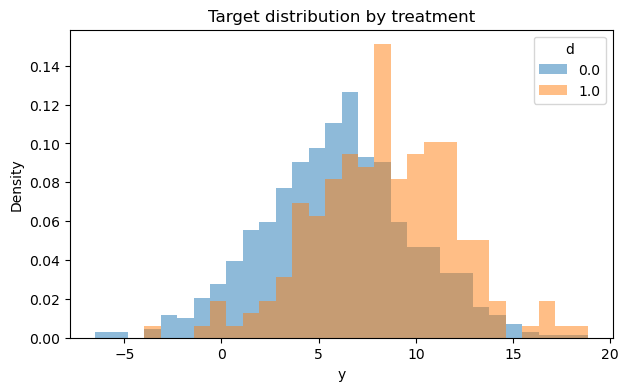

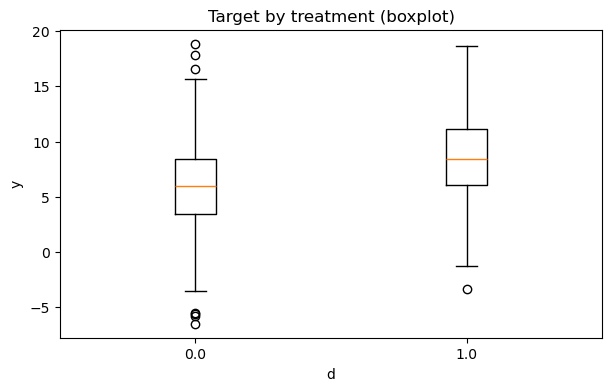

In [4]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [5]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
premium_user,0.205665,0.409574,0.203909,0.452193
avg_sessions_week,4.752390,5.203737,0.451346,0.227439
tenure_months,23.227969,25.490376,2.262407,0.189916
spend_last_month,98.051449,102.626023,4.574574,0.077029
urban_resident,0.625616,0.627660,0.002044,0.004218


In [6]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6166


In [7]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.103, 'share_above': 0.0, 'flag': True}


In [8]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__spend_last_month,-0.002308,0.267708,1.306966,0.042589,-0.000337
1,num__tenure_months,0.002188,0.264734,1.303084,0.042078,0.000320
2,num__avg_sessions_week,-0.001180,0.336046,1.399403,0.054563,-0.000173
3,num__urban_resident,0.001072,0.115448,1.122377,0.017525,0.000157
4,num__premium_user,0.000227,0.400097,1.491969,0.066190,0.000033


In [9]:
# If your DataFrame has a 'shap_mean' column:
shap_df = shap_values_df.copy()
shap_df['mean_abs_shap'] = shap_df['shap_mean'].abs()
shap_df.sort_values('mean_abs_shap', ascending=False, inplace=True)
display(shap_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed,mean_abs_shap
0,num__spend_last_month,-0.002308,0.267708,1.306966,0.042589,-0.000337,0.002308
1,num__tenure_months,0.002188,0.264734,1.303084,0.042078,0.000320,0.002188
2,num__avg_sessions_week,-0.001180,0.336046,1.399403,0.054563,-0.000173,0.001180
3,num__urban_resident,0.001072,0.115448,1.122377,0.017525,0.000157,0.001072
4,num__premium_user,0.000227,0.400097,1.491969,0.066190,0.000033,0.000227


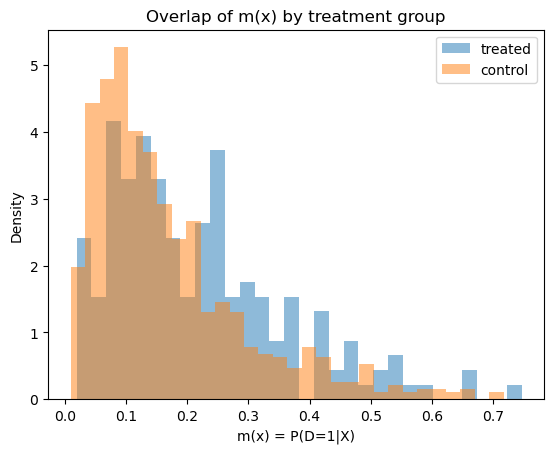

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.740737260683856, 'mae': 2.9370898272431756}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,spend_last_month,0.010719
1,avg_sessions_week,-0.006534
2,tenure_months,-0.004359
3,urban_resident,0.002220
4,premium_user,-0.002046


## Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalkit.inference.ate import dml_ate

# Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, n_folds=4, confidence_level=0.95)

In [14]:
ate_result

{'coefficient': 1.2980190527287987,
 'std_error': 0.5241281531938741,
 'p_value': 0.01326665053030518,
 'confidence_interval': (0.2707467491853135, 2.3252913562722837),
 'model': <causalkit.inference.estimators.irm.IRM at 0x166be23c0>,
 'diagnostic_data': {'m_hat': array([0.20554844, 0.1290321 , 0.07803345, 0.38031118, 0.02856343,
         0.35743388, 0.37884481, 0.11353256, 0.41199118, 0.09352875,
         0.07866502, 0.35511589, 0.0693616 , 0.02622509, 0.08416825,
         0.05340323, 0.12058671, 0.0883763 , 0.07757752, 0.07916583,
         0.36273034, 0.15175503, 0.17368866, 0.05999416, 0.037057  ,
         0.07536295, 0.1532815 , 0.15428353, 0.13052324, 0.36094362,
         0.47640397, 0.25292739, 0.14913619, 0.16168426, 0.22868709,
         0.12201928, 0.15862311, 0.13894857, 0.54909793, 0.22305202,
         0.06945172, 0.1366775 , 0.08916942, 0.14531935, 0.38454672,
         0.28987717, 0.56712005, 0.62165301, 0.03733184, 0.23099293,
         0.07214677, 0.11952243, 0.06742463, 0

True theta in our data generating proccess was 1.8

## Refutation

### Overlap

In [15]:
from  causalkit.refutation import *
rep = run_overlap_diagnostics(res=ate_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.010000,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.193559,GREEN
5,AUC,0.615298,GREEN
6,ESS_treated_ratio,0.505788,GREEN
7,ESS_control_ratio,0.946579,GREEN
8,tails_w1_q99/med,10.453078,YELLOW
9,tails_w0_q99/med,3.212849,GREEN


    ### Score

In [17]:
from causalkit.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=ate_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,0.524128,NA
1,psi_p99_over_med,18.481829,YELLOW
2,psi_kurtosis,69.524320,RED
3,max_|t|_g1,3.346027,YELLOW
4,max_|t|_g0,1.127317,GREEN
5,max_|t|_m,1.750722,GREEN
6,oos_tstat_fold,0.000000,GREEN
7,oos_tstat_strict,0.000000,GREEN


### SUTVA

In [19]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure confounders, treatment, and outcome in the same intervals?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Uncofoundedness

In [23]:
from causalkit.refutation.unconfoundedness.uncofoundedness_validation import run_unconfoundedness_diagnostics

rep_uc = run_unconfoundedness_diagnostics(res=ate_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,6.194497e-02,GREEN
1,balance_frac_violations,0.000000e+00,GREEN
2,ess_treated_ratio,5.057881e-01,RED
3,ess_control_ratio,9.465794e-01,GREEN
4,w_tail_ratio_treated,2.293126e+13,RED
5,w_tail_ratio_control,2.170917e+00,GREEN
6,top1_mass_share_treated,2.269832e-01,GREEN
7,top1_mass_share_control,2.818151e-02,GREEN
8,ks_m_treated_vs_control,1.935594e-01,GREEN
9,pct_m_outside_overlap,0.000000e+00,GREEN


In [22]:
# Python
from causalkit.refutation.unconfoundedness.uncofoundedness_validation import (
    sensitivity_analysis, get_sensitivity_summary,
)

summary_str = sensitivity_analysis(ate_result, cf_y=0.01, cf_d=0.1, rho=1.0, level=0.95)
print(get_sensitivity_summary(ate_result))  # or print(summary_str)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.01; cf_d=0.1, rho=1.0

------------------ Bounds with CI    ------------------
          CI lower  theta lower           theta  theta upper      CI upper
     d    0.270747    -5.639704        1.298019     8.235742      2.325291

------------------ Robustness (SNR proxy) -------------
          H_0   SNR proxy (%)  adj (%)
     d    0.0       28.764315 23.764315
